In [814]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tt

class SimplePDE:
  """
  Solve simple diffusion problem on [0,1] using P1 finite elements.
  """

  def __init__(self, N):
    self.N = N

  def matrix(self, coeff):
    """
    Assemble components of matrix.
    """

    if len(coeff) != 2:
      raise Exception(f"Wrong number of matrix components ({len(coeff)} != 2).")

    # diffusion component
    [num_coeff, nx, I] = np.shape(coeff[0])
    a = coeff[0][0,:,:]
    A0 = []
    for i in range(I):        
      # assemble A, a piecewise constant on grid
      # linearly dependent on a
      Ai = np.zeros((self.N+1,self.N+1))
      Ai.flat[self.N+2::self.N+2] = (a[1:,i] + a[:-1, i]) * self.N # set diag
      Ai.flat[1::self.N+2] = -a[:,i] * self.N # set first upper diag
      Ai.flat[self.N+1::self.N+2] = -a[:,i] * self.N # set first lower diag
      Ai[[0,-1]] = 0 # for dirichlet boundary
      A0.append(Ai)

    # constant part (from boundary)
    [num_coeff, nx, I] = np.shape(coeff[1])
    A1 = []
    for i in range(I):
      # constant part of matrix
      Ai = np.zeros((self.N+1,self.N+1))
      Ai[0,0] = 1
      Ai[-1,-1] = 1
      
      # convection
      v = 50.
      Ai.flat[1::self.N+2] = v# set first upper diag
      Ai.flat[self.N+1::self.N+2] = -v # set first lower diag
      Ai[0,1] = 0
      Ai[-1,-2] = 0 # for dirichlet boundary
      A1.append(Ai)

    return [A0, A1]
  
  def rhs(self, coeff):
    """
    Assemble components of rhs.
    """

    if len(coeff) != 1:
      raise Exception(f"Wrong number of rhs components ({len(coeff)} != 1).")
    
    [num_coeff, nx, I] = np.shape(coeff[0])
    
    # constant rhs
    F0 = []
    for i in range(I):
      # constant part of rhs
      Fi = np.full((self.N+1,1), 10/(self.N)) # assume RHS = 1 
      Fi[[0,-1]] = 0 # boundary condition
      F0.append(Fi)

    return [F0]

  def solve(self, coeff):
    """
    Assemble and solve FE problem for coeff.
    """
    I = np.shape(coeff[0][0])[2]
    
    U = []

    for i in range(I):
      A = self.matrix([coeff[0][k][:,:,i, np.newaxis] for k in range(len(coeff[0]))])
      b = self.rhs([coeff[1][k][:,:,i, np.newaxis] for k in range(len(coeff[1]))])
      U.append(np.linalg.solve(A[0][0] + A[1][0], b[0][0]).reshape((-1,1)))
    
    return U

class diffusion_coeff:

  def __init__(self, Nx, Ny, offset, var):
    self.Nx = Nx
    self.Ny = Ny
    self.offset = offset
    self.var = var

  def __call__(self, X):
    c = np.full(len(X), self.offset,dtype=float)
    for i, x in enumerate(X):
      k = np.arange(1,len(x))
      c[i] += np.sum(np.exp(-k) * np.sin(np.pi*k*x[0]/(self.Nx-1)) \
                      * (x[k]/(self.Ny-1) - 0.5) * self.var)
    return c

### PDE test

Solve the PDE using P1 finite elements for a random parameter

Text(0, 0.5, 'A')

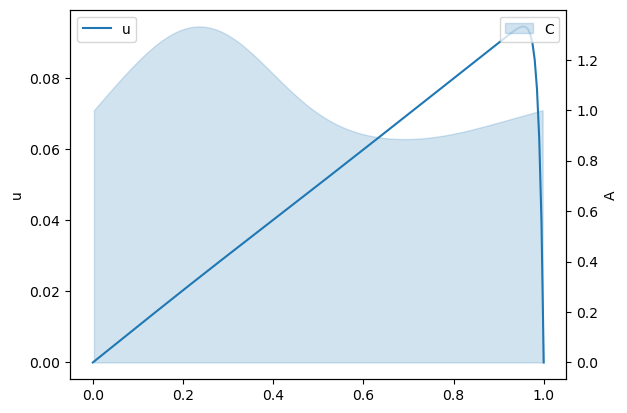

In [815]:
Nx = 200    # spatial resolution
Ny = 5       # parameter resolution
n_a_param = 5 # number of parameters for diffusion coeff
n_param = n_a_param + 1
offset = 1   # parameter mean
var = 4       # 'variance' of the parameters

# get random params
rng = np.random.default_rng()
y = rng.uniform(0, Ny-1, n_a_param)
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1]), np.zeros((Nx,1))])

cfun = diffusion_coeff(Nx, Ny, offset, var)

C_true = cfun(X)

PDE_fun = SimplePDE(Nx)

U = PDE_fun.solve([[C_true.reshape(1,-1,1), np.ones((1,1,1))], [np.ones((1,1,1))]])
U = np.ravel(U[0])

fig, ax = plt.subplots()
ax2 = ax.twinx()

x = np.arange(Nx+1) / Nx
midpoints = (np.arange(Nx) + 0.5) / Nx
p = ax.plot(x, U, label='u')
ax2.fill_between((np.arange(len(C_true)) + 0.5) / (len(C_true)), C_true, alpha=0.2, color=p[0].get_color(), label='C')

ax.set_ylabel('u')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('A')

### Get TT approx of coefficient

In [816]:
from tt import cross

# random init tensor
C_a = tt.rand(np.array([Nx] + [Ny] * n_param),r=3)
# compute TT approx using TT-cross
C_a = tt.cross.rect_cross.cross(cfun, C_a, eps = 1e-8, kickrank=1)
C_a = C_a.round(1e-12)

print("Coefficient ranks: ", C_a.r)
print("Coefficient dims: ", C_a.n)

swp: 0/9 er_rel = 7.2e+00 er_abs = 1.4e+04 erank = 5.1 fun_eval: 2460
swp: 1/9 er_rel = 2.9e-02 er_abs = 5.6e+01 erank = 8.3 fun_eval: 7325
swp: 2/9 er_rel = 6.6e-03 er_abs = 1.3e+01 erank = 13.4 fun_eval: 17620
swp: 3/9 er_rel = 1.2e-15 er_abs = 2.4e-12 erank = 19.0 fun_eval: 37430
Coefficient ranks:  [1 7 6 5 4 3 2 1]
Coefficient dims:  [200   5   5   5   5   5   5]


### Test TT approx

Compare TT approx of coefficient $A$ vs the true coefficient $A$ for the random parameter sample from above

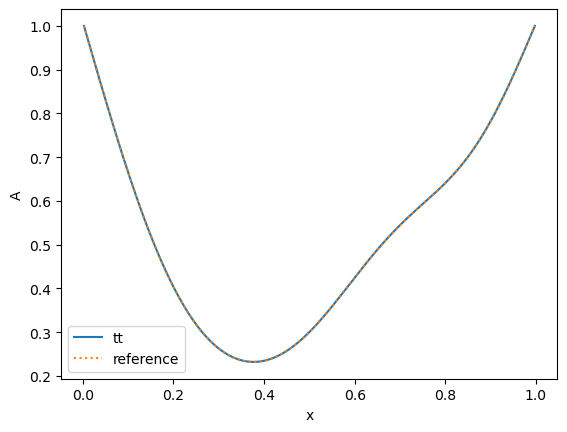

In [817]:
# eval TT-approx of coeff
y = rng.integers(0, Ny, n_a_param)
C_eval = np.empty(Nx)
for i in range(Nx):
  C_eval[i] = C_a[np.concatenate([[i, 0], y])]

X = np.hstack([np.arange(Nx).reshape((-1,1)), np.zeros((Nx,1)), np.tile(y, [Nx,1])])
C_true = cfun(X)

fig, ax = plt.subplots()

x = (np.arange(0, Nx) + .5) / Nx
ax.plot(x, C_eval, label='tt')
ax.plot(x, C_true, ls='dotted', label="reference")
ax.set_xlabel('x')
ax.set_ylabel('A')
ax.legend()

In [818]:
# helper tensor that is constant 1
cores = [np.ones((1,1,1))]
for i in range(n_param):
  cores += [np.ones((1,Ny,1))]

C_const = tt.vector.from_list(cores)

### ALS-cross test

In [819]:
from als_cross_LSTSQ import als_cross_lstsq as als_cross
# from als_cross import als_cross

test = als_cross(
  [C_a, C_const],
  [C_const],
  PDE_fun,
  1e-8,
  random_init=10,
  kickrank=5
  )

test.iterate(3)
print(test.get_stats())

u = test.get_tensor()

print('Ranks', u.r)

= swp=1 core 0, max_dx=1.000e+00, max_rank = 10
= swp=1 core 1>, dx=1.000e+00, rank = [15, 14]
= swp=1 core 2>, dx=1.000e+00, rank = [14, 14]
= swp=1 core 3>, dx=1.000e+00, rank = [14, 11]
= swp=1 core 4>, dx=1.000e+00, rank = [11, 7]
= swp=1 core 5>, dx=1.000e+00, rank = [7, 4]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 15
= swp=2 core <6, dx=0.000e+00, rank = [4, 1]
= swp=2 core <5, dx=5.617e-11, rank = [7, 4]
= swp=2 core <4, dx=3.567e-09, rank = [11, 7]
= swp=2 core <3, dx=1.237e-07, rank = [16, 11]
= swp=2 core <2, dx=7.735e-07, rank = [18, 16]
= swp=2 core <1, dx=6.218e-05, rank = [20, 18]
= swp=3 core 0, max_dx=6.218e-05, max_rank = 20
= swp=3 core 1>, dx=6.986e-07, rank = [25, 22]
= swp=3 core 2>, dx=7.199e-07, rank = [22, 20]
= swp=3 core 3>, dx=1.255e-07, rank = [20, 14]
= swp=3 core 4>, dx=3.212e-08, rank = [14, 8]
= swp=3 core 5>, dx=3.560e-09, rank = [8, 4]
= swp=3 fwd finish, max_dx=7.199e-07, max_rank = 25
{'t_solve': 0.007378546928521246, 't_project': 0.1131744070

### Test ALS-cross accuracy

Compare ALS cross approximation vs PDE solution for a random sample

In [820]:
N_MC = 500
err = 0

for n in range(N_MC):
  # get random parameter
  y = rng.integers(0, Ny, n_param)
  X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1])])

  C_a_true = cfun(X) # compute true coeff

  U = PDE_fun.solve([[C_a_true.reshape(1,-1,1), np.zeros((1,1,1))], [np.zeros((1,1,1))]]) # solve PDE
  U = np.ravel(U)

  # eval ALS-cross
  U_eval = np.empty(u.n[0])
  for i in range(u.n[0]):
    U_eval[i] = u[np.concatenate(([i], y))]

  err += np.sum(np.square(U - U_eval))

err = np.sqrt(err / N_MC)

print(f'RMS l2 err = {err:.2e}')


RMS l2 err = 1.88e-07


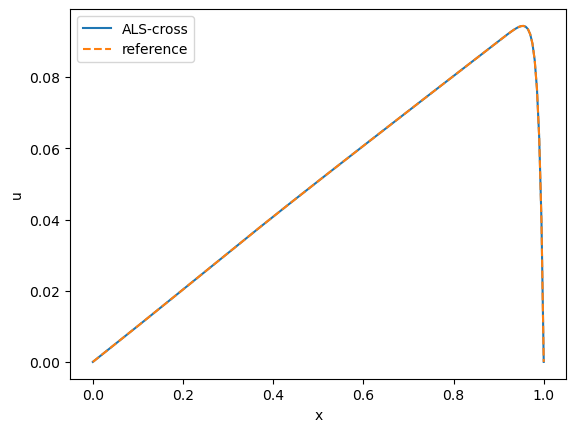

In [821]:
# get random parameter
y = rng.integers(0, Ny, n_param)
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1])])

C_a_true = cfun(X) # compute true coeff

U = PDE_fun.solve([[C_a_true.reshape(1,-1,1), np.zeros((1,1,1))], [np.zeros((1,1,1))]]) # solve PDE
U = np.ravel(U)

# eval ALS-cross
U_eval = np.empty(u.n[0])
for i in range(u.n[0]):
  U_eval[i] = u[np.concatenate(([i], y))]

fig, ax = plt.subplots()

x = np.arange(0, Nx+1) / Nx
ax.plot(x, U_eval, label='ALS-cross')
ax.plot(x, U, ls='dashed', label='reference')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()